In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
import scipy
import math
import random
import sklearn

In [ ]:
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse.linalg import svds

In [ ]:

from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
articles_df = pd.read_csv('/content/drive/MyDrive/shared_articles.csv')

In [ ]:
articles_df = articles_df[articles_df['eventType'] == 'CONTENT SHARED']

In [ ]:
articles_df.head()

,timestamp,eventType,contentId,authorPersonId,authorSessionId,authorUserAgent,authorRegion,authorCountry,contentType,url,title,text,lang
1,1459193988,CONTENT SHARED,-4110354420726924665,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://www.nytimes.com/2016/03/28/business/dea...,"Ethereum, a Virtual Currency, Enables Transact...",All of this work is still very early. The firs...,en
2,1459194146,CONTENT SHARED,-7292285110016212249,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://cointelegraph.com/news/bitcoin-future-w...,Bitcoin Future: When GBPcoin of Branson Wins O...,The alarm clock wakes me at 8:00 with stream o...,en
3,1459194474,CONTENT SHARED,-6151852268067518688,3891637997717104548,-1457532940883382585,NaN,NaN,NaN,HTML,https://cloudplatform.googleblog.com/2016/03/G...,Google Data Center 360° Tour,We're excited to share the Google Data Center ...,en
4,1459194497,CONTENT SHARED,2448026894306402386,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,https://bitcoinmagazine.com/articles/ibm-wants...,"IBM Wants to ""Evolve the Internet"" With Blockc...",The Aite Group projects the blockchain market ...,en
5,1459194522,CONTENT SHARED,-2826566343807132236,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://www.coindesk.com/ieee-blockchain-oxford...,IEEE to Talk Blockchain at Cloud Computing Oxf...,One of the largest and oldest organizations fo...,en


In [ ]:
users = pd.read_csv('/content/drive/MyDrive/users_interactions.csv')

In [ ]:
users.head()

,timestamp,eventType,contentId,personId,sessionId,userAgent,userRegion,userCountry
0,1465413032,VIEW,-3499919498720038879,-8845298781299428018,1264196770339959068,NaN,NaN,NaN
1,1465412560,VIEW,8890720798209849691,-1032019229384696495,3621737643587579081,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_2...,NY,US
2,1465416190,VIEW,310515487419366995,-1130272294246983140,2631864456530402479,NaN,NaN,NaN
3,1465413895,FOLLOW,310515487419366995,344280948527967603,-3167637573980064150,NaN,NaN,NaN
4,1465412290,VIEW,-7820640624231356730,-445337111692715325,5611481178424124714,NaN,NaN,NaN


In [ ]:
event_type_strength = {
   'VIEW': 1.0,
   'LIKE': 2.0,
   'BOOKMARK': 2.5,
   'FOLLOW': 3.0,
   'COMMENT CREATED': 4.0,
}

In [ ]:
users['eventStrength'] = users['eventType'].apply(lambda x: event_type_strength[x])

In [ ]:
users_interactions_count_df = users.groupby(['personId', 'contentId']).size().groupby('personId').size()
print('# users: %d' % len(users_interactions_count_df))

# users: 1895


In [ ]:
users_with_enough_interactions_df = users_interactions_count_df[users_interactions_count_df >= 5].reset_index()[['personId']]
print('# users with at least 5 interactions: %d' % len(users_with_enough_interactions_df))

# users with at least 5 interactions: 1140


In [ ]:
print('# of interactions: %d' % len(users))

# of interactions: 72312


In [ ]:
interactions_from_selected_users_df = users.merge(users_with_enough_interactions_df,
               how = 'right',
               left_on = 'personId',
               right_on = 'personId')
print('# of interactions from users with at least 5 interactions: %d' % len(interactions_from_selected_users_df))

# of interactions from users with at least 5 interactions: 69868


In [ ]:
def smooth_user_preference(x):
    return math.log(1+x, 2)

In [ ]:
interactions_full_df = interactions_from_selected_users_df \
                    .groupby(['personId', 'contentId'])['eventStrength'].sum() \
                    .apply(smooth_user_preference).reset_index()
print('# of unique user/item interactions: %d' % len(interactions_full_df))
interactions_full_df.head()

# of unique user/item interactions: 39106


,personId,contentId,eventStrength
0,-9223121837663643404,-8949113594875411859,1.000000
1,-9223121837663643404,-8377626164558006982,1.000000
2,-9223121837663643404,-8208801367848627943,1.000000
3,-9223121837663643404,-8187220755213888616,1.000000
4,-9223121837663643404,-7423191370472335463,3.169925


,timestamp,eventType,contentId,personId,sessionId,userAgent,userRegion,userCountry,eventStrength
0,1465413032,VIEW,-3499919498720038879,-8845298781299428018,1264196770339959068,NaN,NaN,NaN,1.0
1,1465412560,VIEW,8890720798209849691,-1032019229384696495,3621737643587579081,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_2...,NY,US,1.0
2,1465416190,VIEW,310515487419366995,-1130272294246983140,2631864456530402479,NaN,NaN,NaN,1.0
3,1465413895,FOLLOW,310515487419366995,344280948527967603,-3167637573980064150,NaN,NaN,NaN,3.0
4,1465412290,VIEW,-7820640624231356730,-445337111692715325,5611481178424124714,NaN,NaN,NaN,1.0


In [ ]:
users_train, users_test = train_test_split(interactions_full_df,
                                   stratify=interactions_full_df['personId'],
                                   test_size=0.20,
                                   random_state=42)

In [ ]:
print('# interactions on Train set: %d' % len(users_train))
print('# interactions on Test set: %d' % len(users_test))

# interactions on Train set: 31284
# interactions on Test set: 7822


In [ ]:
interactions_full_indexed_df = interactions_full_df.set_index('personId')
interactions_train_indexed_df = users_train.set_index('personId')
interactions_test_indexed_df = users_test.set_index('personId')

In [ ]:
def get_items_interacted(person_id, users):
    interacted_items = users.loc[person_id]['contentId']
    return set(interacted_items if type(interacted_items) == pd.Series else [interacted_items])

In [ ]:
EVAL_RANDOM_SAMPLE_NON_INTERACTED_ITEMS = 100

class ModelEvaluator1:


    def get_not_interacted_items_sample(self, person_id, sample_size, seed=42):
        interacted_items = get_items_interacted(person_id, interactions_full_indexed_df)
        all_items = set(articles_df['contentId'])
        non_interacted_items = all_items - interacted_items

        random.seed(seed)
        non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
        return set(non_interacted_items_sample)

    def _verify_hit_top_n(self, item_id, recommended_items, topn):
            try:
                index = next(i for i, c in enumerate(recommended_items) if c == item_id)
            except:
                index = -1
            hit = int(index in range(0, topn))
            return hit, index

    def evaluate_model_for_user(self, model, person_id):
        #Getting the items in test set
        interacted_values_testset = interactions_test_indexed_df.loc[person_id]
        if type(interacted_values_testset['contentId']) == pd.Series:
            person_interacted_items_testset = set(interacted_values_testset['contentId'])
        else:
            person_interacted_items_testset = set([int(interacted_values_testset['contentId'])])
        interacted_items_count_testset = len(person_interacted_items_testset)

        #Getting a ranked recommendation list from a model for a given user
        person_recs_df = model.recommend_items(person_id,
                                               items_to_ignore=get_items_interacted(person_id,
                                                                                    interactions_train_indexed_df),
                                               topn=10000000000)

        hits_at_5_count = 0
        hits_at_10_count = 0
        #For each item the user has interacted in test set
        for item_id in person_interacted_items_testset:
            #Getting a random sample (100) items the user has not interacted
            #(to represent items that are assumed to be no relevant to the user)
            non_interacted_items_sample = self.get_not_interacted_items_sample(person_id,
                                                                          sample_size=EVAL_RANDOM_SAMPLE_NON_INTERACTED_ITEMS,
                                                                          seed=item_id%(2**32))

            #Combining the current interacted item with the 100 random items
            items_to_filter_recs = non_interacted_items_sample.union(set([item_id]))

            #Filtering only recommendations that are either the interacted item or from a random sample of 100 non-interacted items
            valid_recs_df = person_recs_df[person_recs_df['contentId'].isin(items_to_filter_recs)]
            valid_recs = valid_recs_df['contentId'].values
            #Verifying if the current interacted item is among the Top-N recommended items
            hit_at_5, index_at_5 = self._verify_hit_top_n(item_id, valid_recs, 5)
            hits_at_5_count += hit_at_5
            hit_at_10, index_at_10 = self._verify_hit_top_n(item_id, valid_recs, 10)
            hits_at_10_count += hit_at_10

        #Recall is the rate of the interacted items that are ranked among the Top-N recommended items,
        #when mixed with a set of non-relevant items
        recall_at_5 = hits_at_5_count / float(interacted_items_count_testset)
        recall_at_10 = hits_at_10_count / float(interacted_items_count_testset)

        person_metrics = {'hits@5_count':hits_at_5_count,
                          'hits@10_count':hits_at_10_count,
                          'interacted_count': interacted_items_count_testset,
                          'recall@5': recall_at_5,
                          'recall@10': recall_at_10}
        return person_metrics

    def evaluate_model(self, model):
        #print('Running evaluation for users')
        people_metrics = []
        for idx, person_id in enumerate(list(interactions_test_indexed_df.index.unique().values)):
            #if idx % 100 == 0 and idx > 0:
            #    print('%d users processed' % idx)
            person_metrics = self.evaluate_model_for_user(model, person_id)
            person_metrics['_person_id'] = person_id
            people_metrics.append(person_metrics)
        print('%d users processed' % idx)

        detailed_results_df = pd.DataFrame(people_metrics) \
                            .sort_values('interacted_count', ascending=False)

        global_recall_at_5 = detailed_results_df['hits@5_count'].sum() / float(detailed_results_df['interacted_count'].sum())
        global_recall_at_10 = detailed_results_df['hits@10_count'].sum() / float(detailed_results_df['interacted_count'].sum())

        global_metrics = {'modelName': model.get_model_name(),
                          'recall@5': global_recall_at_5,
                          'recall@10': global_recall_at_10}
        return global_metrics, detailed_results_df

model_evaluator = ModelEvaluator()

In [ ]:
item_popularity_df = interactions_full_df.groupby('contentId')['eventStrength'].sum().sort_values(ascending=False).reset_index()
item_popularity_df.head()

,contentId,eventStrength
0,-4029704725707465084,307.733799
1,-6783772548752091658,233.762157
2,-133139342397538859,228.024567
3,-8208801367848627943,197.107608
4,-6843047699859121724,193.825208


In [ ]:
import pandas as pd
import numpy as np
import random
import math

# Constants
EVAL_RANDOM_SAMPLE_NON_INTERACTED_ITEMS = 100

# Helper function to get items a user has interacted with
def get_items_interacted(person_id, interactions_df):
    interacted_items = interactions_df[interactions_df['contentId'] == person_id]['contentId'].values
    return set(interacted_items)

# ModelEvaluator class
class ModelEvaluator:
    def get_not_interacted_items_sample(self, person_id, sample_size, seed=42):
        interacted_items = get_items_interacted(person_id, interactions_full_indexed_df)
        all_items = set(articles_df['contentId'])
        non_interacted_items = all_items - interacted_items
        random.seed(seed)
        non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
        return set(non_interacted_items_sample)

    def _verify_hit_top_n(self, item_id, recommended_items, topn):
        try:
            index = next(i for i, c in enumerate(recommended_items) if c == item_id)
        except:
            index = -1
        hit = int(index in range(0, topn))
        return hit, index

    def evaluate_model_for_user(self, model, person_id):
        interacted_values_testset = interactions_test_indexed_df.loc[person_id]
        if isinstance(interacted_values_testset['contentId'], pd.Series):
            person_interacted_items_testset = set(interacted_values_testset['contentId'])
        else:
            person_interacted_items_testset = {int(interacted_values_testset['contentId'])}

        interacted_items_count_testset = len(person_interacted_items_testset)

        # Get model recommendations
        person_recs_df = model.recommend_items(
            person_id,
            items_to_ignore=get_items_interacted(person_id, interactions_train_indexed_df),
            topn=10000000000,
        )

        hits_at_5_count = 0
        hits_at_10_count = 0
        reciprocal_ranks = []
        dcg = 0  # Discounted Cumulative Gain (DCG)

        for item_id in person_interacted_items_testset:
            # Get a random sample of non-interacted items
            non_interacted_items_sample = self.get_not_interacted_items_sample(
                person_id,
                sample_size=EVAL_RANDOM_SAMPLE_NON_INTERACTED_ITEMS,
                seed=item_id % (2**32),
            )

            items_to_filter_recs = non_interacted_items_sample.union({item_id})
            valid_recs_df = person_recs_df[person_recs_df['contentId'].isin(items_to_filter_recs)]
            valid_recs = valid_recs_df['contentId'].values

            # Check if the current interacted item is in the Top-5 or Top-10
            hit_at_5, index_at_5 = self._verify_hit_top_n(item_id, valid_recs, 5)
            hits_at_5_count += hit_at_5
            hit_at_10, index_at_10 = self._verify_hit_top_n(item_id, valid_recs, 10)
            hits_at_10_count += hit_at_10

            if index_at_5 >= 0:
                reciprocal_ranks.append(1 / (index_at_5 + 1))  # Reciprocal rank
                dcg += 1 / math.log2(index_at_5 + 2)  # DCG calculation

        # Metrics for each user
        recall_at_5 = hits_at_5_count / interacted_items_count_testset
        recall_at_10 = hits_at_10_count / interacted_items_count_testset
        mrr = np.mean(reciprocal_ranks)  # Mean Reciprocal Rank
        idcg = sum(1 / math.log2(i + 2) for i in range(interacted_items_count_testset))  # Ideal DCG
        ndcg = dcg / idcg if idcg > 0 else 0  # Normalized DCG

        # Store metrics
        person_metrics = {
            'hits@5_count': hits_at_5_count,
            'hits@10_count': hits_at_10_count,
            'interacted_count': interacted_items_count_testset,
            'recall@5': recall_at_5,
            'recall@10': recall_at_10,
            'mrr': mrr,
            'ndcg': ndcg,
        }
        return person_metrics

    # Evaluate the model across all users in the test set
    def evaluate_model(self, model):
        people_metrics = []
        for person_id in interactions_test_indexed_df.index.unique():
            person_metrics = self.evaluate_model_for_user(model, person_id)
            person_metrics['_person_id'] = person_id
            people_metrics.append(person_metrics)

        detailed_results_df = pd.DataFrame(people_metrics).sort_values('interacted_count', ascending=False)

        # Global metrics
        global_recall_at_5 = detailed_results_df['hits@5_count'].sum() / detailed_results_df['interacted_count'].sum()
        global_recall_at_10 = detailed_results_df['hits@10_count'].sum() / detailed_results_df['interacted_count'].sum()
        global_mrr = detailed_results_df['mrr'].mean()  # Mean Reciprocal Rank
        global_ndcg = detailed_results_df['ndcg'].mean()  # Normalized DCG

        global_metrics = {
            'modelName': model.get_model_name(),
            'recall@5': global_recall_at_5,
            'recall@10': global_recall_at_10,
            'mrr': global_mrr,
            'ndcg': global_ndcg,
        }

        return global_metrics, detailed_results_df





In [ ]:

# Instantiate the evaluator and the popularity model
model_evaluator = ModelEvaluator()
popularity_model = PopularityRecommender(item_popularity_df, articles_df)

# Evaluate the popularity model
pop_global_metrics, pop_detailed_results_df = model_evaluator.evaluate_model(popularity_model)

# Output the global metrics and top 5 detailed results with recommendations
print('\nGlobal metrics:')
print(f"Model Name: {pop_global_metrics['modelName']}")
print(f"Recall@5: {pop_global_metrics['recall@5']:.2f}")
print(f"Recall@10: {pop_global_metrics['recall@10']:.2f}")
print(f"MRR: {pop_global_metrics['mrr']:.2f}")
print(f"nDCG: {pop_global_metrics['ndcg']:.2f}")

print('\nDetailed results (top 5):')
print(pop_detailed_results_df[['recall@5', 'recall@10', 'mrr', 'ndcg', '_person_id']].head(5))

print('\nExample recommendations for user 1:')
recommendations_df = popularity_model.recommend_items(1, topn=10, verbose=True)
recommendations_df.head()

<ipython-input-82-f08abaad994d>:21: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



Global metrics:
Model Name: Popularity
Recall@5: 0.22
Recall@10: 0.35
MRR: 0.22
nDCG: 0.50

Detailed results (top 5):
    recall@5  recall@10       mrr      ndcg           _person_id
76  0.088542   0.187500  0.073914  1.356354  3609194402293569455
17  0.059701   0.164179  0.059416  1.172685 -2626634673110551643
16  0.076923   0.184615  0.071155  1.205599 -1032019229384696495
10  0.034188   0.051282  0.057035  1.071303 -1443636648652872475
82  0.215909   0.363636  0.159167  1.465056 -2979881261169775358

Example recommendations for user 1:


,eventStrength,contentId,title,url,lang
0,307.733799,-4029704725707465084,Former Google career coach shares a visual tri...,http://www.cnbc.com/2016/12/21/former-google-c...,en
1,233.762157,-6783772548752091658,Livro: Retrospectivas Divertidas,http://www.caroli.org/livro-retrospectivas-div...,pt
2,228.024567,-133139342397538859,"Novo workaholic trabalha, pratica esportes e t...",http://gq.globo.com/Prazeres/Poder/Carreira/no...,pt
3,197.107608,-8208801367848627943,Ray Kurzweil: The world isn't getting worse - ...,http://www.geekwire.com/2016/ray-kurzweil-worl...,en
4,193.825208,-6843047699859121724,"Ganhe 6 meses de acesso ao Pluralsight, maior ...",https://medium.com/@jeffersoncn/ganhe-6-meses-...,pt


In [ ]:
class PopularityRecommender:

    MODEL_NAME = 'Popularity'

    def __init__(self, popularity_df, items_df=None):
        self.popularity_df = popularity_df
        self.items_df = items_df

    def get_model_name(self):
        return self.MODEL_NAME

    def recommend_items(self, user_id, items_to_ignore=[], topn=10, verbose=False):
        # Recommend the more popular items that the user hasn't seen yet.
        recommendations_df = self.popularity_df[~self.popularity_df['contentId'].isin(items_to_ignore)] \
                               .sort_values('eventStrength', ascending = False) \
                               .head(topn)

        if verbose:
            if self.items_df is None:
                raise Exception('"items_df" is required in verbose mode')

            recommendations_df = recommendations_df.merge(self.items_df, how = 'left',
                                                          left_on = 'contentId',
                                                          right_on = 'contentId')[['eventStrength', 'contentId', 'title', 'url', 'lang']]


        return recommendations_df

popularity_model = PopularityRecommender(item_popularity_df, articles_df)

In [ ]:
print('Evaluating Popularity recommendation model...')
model_evaluator = ModelEvaluator1()
pop_global_metrics, pop_detailed_results_df = model_evaluator.evaluate_model(popularity_model)
print('\nGlobal metrics:\n%s' % pop_global_metrics)
pop_detailed_results_df.head()

Evaluating Popularity recommendation model...


<ipython-input-88-959db57486a1>:12: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)


1139 users processed

Global metrics:
{'modelName': 'Popularity', 'recall@5': 0.21784709792891843, 'recall@10': 0.354768601380721}


,hits@5_count,hits@10_count,interacted_count,recall@5,recall@10,_person_id
76,17,36,192,0.088542,0.187500,3609194402293569455
17,8,22,134,0.059701,0.164179,-2626634673110551643
16,10,24,130,0.076923,0.184615,-1032019229384696495
10,4,6,117,0.034188,0.051282,-1443636648652872475
82,19,32,88,0.215909,0.363636,-2979881261169775358


In [ ]:

nltk.download('stopwords')
stopwords_list = stopwords.words('english')
#Trains a model whose vectors size is 5000, composed by the main unigrams and bigrams found in the corpus, ignoring stopwords
vectorizer = TfidfVectorizer(analyzer='word',
                     ngram_range=(1, 2),
                     min_df=0.003,
                     max_df=0.5,
                     max_features=5000,
                     stop_words=stopwords_list)

item_ids = articles_df['contentId'].tolist()
tfidf_matrix = vectorizer.fit_transform(articles_df['title'] + "" + articles_df['text'])
tfidf_feature_names = vectorizer.get_feature_names_out()
tfidf_matrix

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


<3047x5000 sparse matrix of type '<class 'numpy.float64'>'
	with 677781 stored elements in Compressed Sparse Row format>

In [ ]:
def get_item_profile(item_id):
    idx = item_ids.index(item_id)
    item_profile = tfidf_matrix[idx:idx+1]
    return item_profile

def get_item_profiles(ids):
    item_profiles_list = [get_item_profile(x) for x in ids]
    item_profiles = scipy.sparse.vstack(item_profiles_list)
    return item_profiles

def build_users_profile(person_id, interactions_indexed_df):
    interactions_person_df = interactions_indexed_df.loc[person_id]
    user_item_profiles = get_item_profiles(interactions_person_df['contentId'])

    user_item_strengths = np.array(interactions_person_df['eventStrength']).reshape(-1,1)
    #Weighted average of item profiles by the interactions strength
    user_item_strengths_weighted_avg = np.sum(user_item_profiles.multiply(user_item_strengths), axis=0) / np.sum(user_item_strengths)
    # Convert to NumPy array
    user_item_strengths_weighted_avg = np.asarray(user_item_strengths_weighted_avg)

# Normalize the array
    user_profile_norm = sklearn.preprocessing.normalize(user_item_strengths_weighted_avg)
    return user_profile_norm

def build_users_profiles():
    interactions_indexed_df = interactions_full_df[interactions_full_df['contentId'] \
                                                   .isin(articles_df['contentId'])].set_index('personId')
    user_profiles = {}
    for person_id in interactions_indexed_df.index.unique():
        user_profiles[person_id] = build_users_profile(person_id, interactions_indexed_df)
    return user_profiles

In [ ]:
user_profiles = build_users_profiles()
len(user_profiles)

1140

In [ ]:
myprofile = user_profiles[-1479311724257856983]
print(myprofile.shape)
pd.DataFrame(sorted(zip(tfidf_feature_names,
                        user_profiles[-1479311724257856983].flatten().tolist()), key=lambda x: -x[1])[:20],
             columns=['token', 'relevance'])

(1, 5000)


,token,relevance
0,learning,0.294228
1,machine learning,0.245745
2,machine,0.236812
3,de,0.201505
4,google,0.194384
5,data,0.166056
6,ai,0.131141
7,que,0.121237
8,algorithms,0.099081
9,graph,0.096097


In [ ]:
class ContentBasedRecommender:

    MODEL_NAME = 'Content-Based'

    def __init__(self, items_df=None):
        self.item_ids = item_ids
        self.items_df = items_df

    def get_model_name(self):
        return self.MODEL_NAME

    def _get_similar_items_to_user_profile(self, person_id, topn=1000):
        #Computes the cosine similarity between the user profile and all item profiles
        cosine_similarities = cosine_similarity(user_profiles[person_id], tfidf_matrix)
        #Gets the top similar items
        similar_indices = cosine_similarities.argsort().flatten()[-topn:]
        #Sort the similar items by similarity
        similar_items = sorted([(item_ids[i], cosine_similarities[0,i]) for i in similar_indices], key=lambda x: -x[1])
        return similar_items

    def recommend_items(self, user_id, items_to_ignore=[], topn=10, verbose=False):
        similar_items = self._get_similar_items_to_user_profile(user_id)
        #Ignores items the user has already interacted
        similar_items_filtered = list(filter(lambda x: x[0] not in items_to_ignore, similar_items))

        recommendations_df = pd.DataFrame(similar_items_filtered, columns=['contentId', 'recStrength']) \
                                    .head(topn)

        if verbose:
            if self.items_df is None:
                raise Exception('"items_df" is required in verbose mode')

            recommendations_df = recommendations_df.merge(self.items_df, how = 'left',
                                                          left_on = 'contentId',
                                                          right_on = 'contentId')[['recStrength', 'contentId', 'title', 'url', 'lang']]


        return recommendations_df

content_based_recommender_model = ContentBasedRecommender(articles_df)

In [ ]:

# Instantiate the evaluator and the popularity model
model_evaluator = ModelEvaluator()
content_based_recommender_model = ContentBasedRecommender(articles_df)
# Evaluate the popularity model
pop_global_metrics, pop_detailed_results_df = model_evaluator.evaluate_model(content_based_recommender_model)

# Output the global metrics and top 5 detailed results with recommendations
print('\nGlobal metrics:')
print(f"Model Name: {pop_global_metrics['modelName']}")
print(f"Recall@5: {pop_global_metrics['recall@5']:.2f}")
print(f"Recall@10: {pop_global_metrics['recall@10']:.2f}")
print(f"MRR: {pop_global_metrics['mrr']:.2f}")
print(f"nDCG: {pop_global_metrics['ndcg']:.2f}")

print('\nDetailed results (top 5):')
print(pop_detailed_results_df[['recall@5', 'recall@10', 'mrr', 'ndcg', '_person_id']].head(5))

print('\nExample recommendations for user 1:')
recommendations_df = popularity_model.recommend_items(1, topn=10, verbose=True)
recommendations_df.head()

<ipython-input-82-f08abaad994d>:21: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
<ipython-input-82-f08abaad994d>:21: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
<ipython-input-82-f08abaad994d>:21: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
<ipython-input-82-f08abaad994d>:21: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
<ipython-input-82-f08abaad994d>:21: DeprecationWarning: Sampling from a set depr


Global metrics:
Model Name: Content-Based
Recall@5: 0.19
Recall@10: 0.27
MRR: 0.29
nDCG: 0.50

Detailed results (top 5):
    recall@5  recall@10       mrr      ndcg           _person_id
76  0.052083   0.109375  0.124684  0.660217  3609194402293569455
17  0.059701   0.089552  0.133778  0.565099 -2626634673110551643
16  0.123077   0.207692  0.192364  0.867519 -1032019229384696495
10  0.170940   0.316239  0.180677  1.145046 -1443636648652872475
82  0.000000   0.034091  0.059720  0.311067 -2979881261169775358

Example recommendations for user 1:


<ipython-input-82-f08abaad994d>:21: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
<ipython-input-82-f08abaad994d>:21: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_meth

,eventStrength,contentId,title,url,lang
0,307.733799,-4029704725707465084,Former Google career coach shares a visual tri...,http://www.cnbc.com/2016/12/21/former-google-c...,en
1,233.762157,-6783772548752091658,Livro: Retrospectivas Divertidas,http://www.caroli.org/livro-retrospectivas-div...,pt
2,228.024567,-133139342397538859,"Novo workaholic trabalha, pratica esportes e t...",http://gq.globo.com/Prazeres/Poder/Carreira/no...,pt
3,197.107608,-8208801367848627943,Ray Kurzweil: The world isn't getting worse - ...,http://www.geekwire.com/2016/ray-kurzweil-worl...,en
4,193.825208,-6843047699859121724,"Ganhe 6 meses de acesso ao Pluralsight, maior ...",https://medium.com/@jeffersoncn/ganhe-6-meses-...,pt


In [ ]:
print('Evaluating Content-Based Filtering model...')
cb_global_metrics, cb_detailed_results_df = model_evaluator.evaluate_model(content_based_recommender_model)
print('\nGlobal metrics:\n%s' % cb_global_metrics)
cb_detailed_results_df.head()

<ipython-input-82-f08abaad994d>:21: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
<ipython-input-82-f08abaad994d>:21: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)


Evaluating Content-Based Filtering model...


<ipython-input-82-f08abaad994d>:21: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
<ipython-input-82-f08abaad994d>:21: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
<ipython-input-82-f08abaad994d>:21: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
<ipython-input-82-f08abaad994d>:21: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
<ipython-input-82-f08abaad994d>:21: DeprecationWarning: Sampling from a set depr


Global metrics:
{'modelName': 'Content-Based', 'recall@5': 0.18818716440807978, 'recall@10': 0.27192533878803377, 'mrr': 0.2947636507945819, 'ndcg': 0.49570080981643383}


<ipython-input-82-f08abaad994d>:21: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


,hits@5_count,hits@10_count,interacted_count,recall@5,recall@10,mrr,ndcg,_person_id
76,10,21,192,0.052083,0.109375,0.124684,0.660217,3609194402293569455
17,8,12,134,0.059701,0.089552,0.133778,0.565099,-2626634673110551643
16,16,27,130,0.123077,0.207692,0.192364,0.867519,-1032019229384696495
10,20,37,117,0.170940,0.316239,0.180677,1.145046,-1443636648652872475
82,0,3,88,0.000000,0.034091,0.059720,0.311067,-2979881261169775358


In [ ]:
users_items_pivot_matrix_df = users_train.pivot(index='personId',
                                                          columns='contentId',
                                                          values='eventStrength').fillna(0)

users_items_pivot_matrix_df.head()

contentId,-9222795471790223670,-9216926795620865886,-9194572880052200111,-9192549002213406534,-9190737901804729417,-9189659052158407108,-9176143510534135851,-9172673334835262304,-9171475473795142532,-9166778629773133902,...,9191014301634017491,9207286802575546269,9208127165664287660,9209629151177723638,9209886322932807692,9213260650272029784,9215261273565326920,9217155070834564627,9220445660318725468,9222265156747237864
personId,,,,,,,,,,,,,,,,,,,,,
-9223121837663643404,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-9212075797126931087,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-9207251133131336884,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-9199575329909162940,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-9196668942822132778,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
import pandas as pd

users_items_pivot_matrix = users_items_pivot_matrix_df.to_numpy()

users_items_pivot_matrix[:10]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 2., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
users_ids = list(users_items_pivot_matrix_df.index)
users_ids[:10]

[-9223121837663643404,
 -9212075797126931087,
 -9207251133131336884,
 -9199575329909162940,
 -9196668942822132778,
 -9188188261933657343,
 -9172914609055320039,
 -9156344805277471150,
 -9120685872592674274,
 -9109785559521267180]

In [ ]:
NUMBER_OF_FACTORS_MF = 15

U, sigma, Vt = svds(users_items_pivot_matrix, k = NUMBER_OF_FACTORS_MF)

In [ ]:
U.shape

(1140, 15)

In [ ]:
Vt.shape

(15, 2926)

In [ ]:
sigma = np.diag(sigma)
sigma.shape

(15, 15)

In [ ]:
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt)
all_user_predicted_ratings

array([[ 0.01039915,  0.00081872, -0.01725263, ...,  0.00140708,
         0.0110647 ,  0.00226063],
       [-0.00019285, -0.00031318, -0.00264624, ...,  0.00251658,
         0.00017609, -0.00189488],
       [-0.01254721,  0.0065947 , -0.00590676, ...,  0.00698975,
        -0.01015696,  0.01154572],
       ...,
       [-0.02995379,  0.00805715, -0.01846307, ..., -0.01083078,
        -0.00118591,  0.0096798 ],
       [-0.01845505,  0.00467019,  0.01219602, ...,  0.00409507,
         0.00019482, -0.00752562],
       [-0.01506374,  0.00327732,  0.13391269, ..., -0.01191815,
         0.06422074,  0.01303244]])

In [ ]:
cf_preds_df = pd.DataFrame(all_user_predicted_ratings, columns = users_items_pivot_matrix_df.columns, index=users_ids).transpose()
cf_preds_df.head()

,-9223121837663643404,-9212075797126931087,-9207251133131336884,-9199575329909162940,-9196668942822132778,-9188188261933657343,-9172914609055320039,-9156344805277471150,-9120685872592674274,-9109785559521267180,...,9105269044962898535,9109075639526981934,9135582630122950040,9137372837662939523,9148269800512008413,9165571805999894845,9187866633451383747,9191849144618614467,9199170757466086545,9210530975708218054
contentId,,,,,,,,,,,,,,,,,,,,,
-9222795471790223670,0.010399,-0.000193,-0.012547,0.052958,-0.010035,-0.005412,-0.003918,0.049302,-0.013458,-0.020052,...,-0.005306,-0.089463,-0.000048,0.015023,0.020953,-0.009394,-0.019114,-0.029954,-0.018455,-0.015064
-9216926795620865886,0.000819,-0.000313,0.006595,-0.000649,0.000151,0.000338,0.000197,0.000861,0.002341,0.001765,...,0.000095,0.013915,0.000506,0.001460,0.014863,0.000940,0.002391,0.008057,0.004670,0.003277
-9194572880052200111,-0.017253,-0.002646,-0.005907,-0.003666,0.021300,-0.001278,0.029100,-0.014730,-0.023410,0.004950,...,0.011529,0.046012,0.010485,0.018768,0.150362,0.019052,0.023870,-0.018463,0.012196,0.133913
-9192549002213406534,0.035081,0.000391,-0.029046,-0.007702,0.017615,0.005496,0.013435,0.057563,0.047532,0.004209,...,0.020149,0.260317,0.007923,-0.008079,0.034164,0.011558,0.013793,-0.010138,0.025703,0.095753
-9190737901804729417,0.019939,-0.004799,0.006684,0.006363,-0.001997,0.002356,0.003876,0.004118,-0.027098,0.019793,...,0.003719,0.004478,0.001917,0.000341,-0.034535,-0.001160,0.001307,0.002957,0.005991,-0.015662


In [ ]:
len(cf_preds_df.columns)

1140

In [ ]:
class CFRecommender:

    MODEL_NAME = 'Collaborative Filtering'

    def __init__(self, cf_predictions_df, items_df=None):
        self.cf_predictions_df = cf_predictions_df
        self.items_df = items_df

    def get_model_name(self):
        return self.MODEL_NAME

    def recommend_items(self, user_id, items_to_ignore=[], topn=10, verbose=False):
        # Get and sort the user's predictions
        sorted_user_predictions = self.cf_predictions_df[user_id].sort_values(ascending=False) \
                                    .reset_index().rename(columns={user_id: 'recStrength'})

        # Recommend the highest predicted rating movies that the user hasn't seen yet.
        recommendations_df = sorted_user_predictions[~sorted_user_predictions['contentId'].isin(items_to_ignore)] \
                               .sort_values('recStrength', ascending = False) \
                               .head(topn)

        if verbose:
            if self.items_df is None:
                raise Exception('"items_df" is required in verbose mode')

            recommendations_df = recommendations_df.merge(self.items_df, how = 'left',
                                                          left_on = 'contentId',
                                                          right_on = 'contentId')[['recStrength', 'contentId', 'title', 'url', 'lang']]


        return recommendations_df

cf_recommender_model = CFRecommender(cf_preds_df, articles_df)

In [ ]:

# Instantiate the evaluator and the popularity model
model_evaluator = ModelEvaluator()
cf_recommender_model = CFRecommender(cf_preds_df, articles_df)
# Evaluate the popularity model
pop_global_metrics, pop_detailed_results_df = model_evaluator.evaluate_model(cf_recommender_model)

# Output the global metrics and top 5 detailed results with recommendations
print('\nGlobal metrics:')
print(f"Model Name: {pop_global_metrics['modelName']}")
print(f"Recall@5: {pop_global_metrics['recall@5']:.2f}")
print(f"Recall@10: {pop_global_metrics['recall@10']:.2f}")
print(f"MRR: {pop_global_metrics['mrr']:.2f}")
print(f"nDCG: {pop_global_metrics['ndcg']:.2f}")

print('\nDetailed results (top 5):')
print(pop_detailed_results_df[['recall@5', 'recall@10', 'mrr', 'ndcg', '_person_id']].head(5))

print('\nExample recommendations for user 1:')
recommendations_df = popularity_model.recommend_items(1, topn=10, verbose=True)
recommendations_df.head()

<ipython-input-82-f08abaad994d>:21: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
<ipython-input-82-f08abaad994d>:21: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
<ipython-input-82-f08abaad994d>:21: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
<ipython-input-82-f08abaad994d>:21: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
<ipython-input-82-f08abaad994d>:21: DeprecationWarning: Sampling from a set depr


Global metrics:
Model Name: Collaborative Filtering
Recall@5: 0.27
Recall@10: 0.40
MRR: 0.26
nDCG: 0.55

Detailed results (top 5):
    recall@5  recall@10       mrr      ndcg           _person_id
76  0.000000   0.000000  0.022272  0.982901  3609194402293569455
17  0.000000   0.000000  0.032963  1.018102 -2626634673110551643
16  0.000000   0.000000  0.027347  0.935737 -1032019229384696495
10  0.000000   0.008547  0.037270  1.001963 -1443636648652872475
82  0.181818   0.318182  0.127670  1.351487 -2979881261169775358

Example recommendations for user 1:


,eventStrength,contentId,title,url,lang
0,307.733799,-4029704725707465084,Former Google career coach shares a visual tri...,http://www.cnbc.com/2016/12/21/former-google-c...,en
1,233.762157,-6783772548752091658,Livro: Retrospectivas Divertidas,http://www.caroli.org/livro-retrospectivas-div...,pt
2,228.024567,-133139342397538859,"Novo workaholic trabalha, pratica esportes e t...",http://gq.globo.com/Prazeres/Poder/Carreira/no...,pt
3,197.107608,-8208801367848627943,Ray Kurzweil: The world isn't getting worse - ...,http://www.geekwire.com/2016/ray-kurzweil-worl...,en
4,193.825208,-6843047699859121724,"Ganhe 6 meses de acesso ao Pluralsight, maior ...",https://medium.com/@jeffersoncn/ganhe-6-meses-...,pt


In [ ]:
print('Evaluating Collaborative Filtering (SVD Matrix Factorization) model...')
cf_global_metrics, cf_detailed_results_df = model_evaluator.evaluate_model(cf_recommender_model)
print('\nGlobal metrics:\n%s' % cf_global_metrics)
cf_detailed_results_df.head()

Evaluating Collaborative Filtering (SVD Matrix Factorization) model...


<ipython-input-82-f08abaad994d>:21: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
<ipython-input-82-f08abaad994d>:21: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
<ipython-input-82-f08abaad994d>:21: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
<ipython-input-82-f08abaad994d>:21: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
<ipython-input-82-f08abaad994d>:21: DeprecationWarning: Sampling from a set depr


Global metrics:
{'modelName': 'Collaborative Filtering', 'recall@5': 0.26834569163896704, 'recall@10': 0.4010483252365124, 'mrr': 0.2642444834119821, 'ndcg': 0.5488309620268558}


<ipython-input-82-f08abaad994d>:21: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


,hits@5_count,hits@10_count,interacted_count,recall@5,recall@10,mrr,ndcg,_person_id
76,0,0,192,0.000000,0.000000,0.022272,0.982901,3609194402293569455
17,0,0,134,0.000000,0.000000,0.032963,1.018102,-2626634673110551643
16,0,0,130,0.000000,0.000000,0.027347,0.935737,-1032019229384696495
10,0,1,117,0.000000,0.008547,0.037270,1.001963,-1443636648652872475
82,16,28,88,0.181818,0.318182,0.127670,1.351487,-2979881261169775358


In [ ]:
class HybridRecommender:

    MODEL_NAME = 'Hybrid'

    def __init__(self, cb_rec_model, cf_rec_model, items_df):
        self.cb_rec_model = cb_rec_model
        self.cf_rec_model = cf_rec_model
        self.items_df = items_df

    def get_model_name(self):
        return self.MODEL_NAME

    def recommend_items(self, user_id, items_to_ignore=[], topn=10, verbose=False):
        #Getting the top-1000 Content-based filtering recommendations
        cb_recs_df = self.cb_rec_model.recommend_items(user_id, items_to_ignore=items_to_ignore, verbose=verbose,
                                                           topn=1000).rename(columns={'recStrength': 'recStrengthCB'})

        #Getting the top-1000 Collaborative filtering recommendations
        cf_recs_df = self.cf_rec_model.recommend_items(user_id, items_to_ignore=items_to_ignore, verbose=verbose,
                                                           topn=1000).rename(columns={'recStrength': 'recStrengthCF'})

        #Combining the results by contentId
        recs_df = cb_recs_df.merge(cf_recs_df,
                                   how = 'inner',
                                   left_on = 'contentId',
                                   right_on = 'contentId')

        #Computing a hybrid recommendation score based on CF and CB scores
        recs_df['recStrengthHybrid'] = recs_df['recStrengthCB'] * recs_df['recStrengthCF']

        #Sorting recommendations by hybrid score
        recommendations_df = recs_df.sort_values('recStrengthHybrid', ascending=False).head(topn)

        if verbose:
            if self.items_df is None:
                raise Exception('"items_df" is required in verbose mode')

            recommendations_df = recommendations_df.merge(self.items_df, how = 'left',
                                                          left_on = 'contentId',
                                                          right_on = 'contentId')[['recStrengthHybrid', 'contentId', 'title', 'url', 'lang']]


        return recommendations_df

hybrid_recommender_model = HybridRecommender(content_based_recommender_model, cf_recommender_model, articles_df)

In [ ]:

# Instantiate the evaluator and the popularity model
model_evaluator = ModelEvaluator()
hybrid_recommender_model = HybridRecommender(content_based_recommender_model, cf_recommender_model, articles_df)# Evaluate the popularity model
pop_global_metrics, pop_detailed_results_df = model_evaluator.evaluate_model(hybrid_recommender_model)

# Output the global metrics and top 5 detailed results with recommendations
print('\nGlobal metrics:')
print(f"Model Name: {pop_global_metrics['modelName']}")
print(f"Recall@5: {pop_global_metrics['recall@5']:.2f}")
print(f"Recall@10: {pop_global_metrics['recall@10']:.2f}")
print(f"MRR: {pop_global_metrics['mrr']:.2f}")
print(f"nDCG: {pop_global_metrics['ndcg']:.2f}")

print('\nDetailed results (top 5):')
print(pop_detailed_results_df[['recall@5', 'recall@10', 'mrr', 'ndcg', '_person_id']].head(5))

print('\nExample recommendations for user 1:')
recommendations_df = popularity_model.recommend_items(1, topn=10, verbose=True)
recommendations_df.head()

<ipython-input-82-f08abaad994d>:21: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
<ipython-input-82-f08abaad994d>:21: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
<ipython-input-82-f08abaad994d>:21: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
<ipython-input-82-f08abaad994d>:21: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
<ipython-input-82-f08abaad994d>:21: DeprecationWarning: Sampling from a set depr


Global metrics:
Model Name: Hybrid
Recall@5: 0.32
Recall@10: 0.43
MRR: 0.45
nDCG: 0.53

Detailed results (top 5):
    recall@5  recall@10       mrr      ndcg           _person_id
76  0.000000   0.020833  0.084231  0.144386  3609194402293569455
17  0.022388   0.111940  0.122845  0.286513 -2626634673110551643
16  0.007692   0.084615  0.098879  0.315652 -1032019229384696495
10  0.008547   0.085470  0.081031  0.497958 -1443636648652872475
82  0.102273   0.170455  0.267081  0.427914 -2979881261169775358

Example recommendations for user 1:


<ipython-input-82-f08abaad994d>:21: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
<ipython-input-82-f08abaad994d>:21: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_meth

,eventStrength,contentId,title,url,lang
0,307.733799,-4029704725707465084,Former Google career coach shares a visual tri...,http://www.cnbc.com/2016/12/21/former-google-c...,en
1,233.762157,-6783772548752091658,Livro: Retrospectivas Divertidas,http://www.caroli.org/livro-retrospectivas-div...,pt
2,228.024567,-133139342397538859,"Novo workaholic trabalha, pratica esportes e t...",http://gq.globo.com/Prazeres/Poder/Carreira/no...,pt
3,197.107608,-8208801367848627943,Ray Kurzweil: The world isn't getting worse - ...,http://www.geekwire.com/2016/ray-kurzweil-worl...,en
4,193.825208,-6843047699859121724,"Ganhe 6 meses de acesso ao Pluralsight, maior ...",https://medium.com/@jeffersoncn/ganhe-6-meses-...,pt


In [ ]:
print('Evaluating Hybrid model...')
hybrid_global_metrics, hybrid_detailed_results_df = model_evaluator.evaluate_model(hybrid_recommender_model)
print('\nGlobal metrics:\n%s' % hybrid_global_metrics)
hybrid_detailed_results_df.head()

<ipython-input-82-f08abaad994d>:21: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
<ipython-input-82-f08abaad994d>:21: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)


Evaluating Hybrid model...


<ipython-input-82-f08abaad994d>:21: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
<ipython-input-82-f08abaad994d>:21: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
<ipython-input-82-f08abaad994d>:21: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
<ipython-input-82-f08abaad994d>:21: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
<ipython-input-82-f08abaad994d>:21: DeprecationWarning: Sampling from a set depr


Global metrics:
{'modelName': 'Hybrid', 'recall@5': 0.31628739452825366, 'recall@10': 0.4344157504474559, 'mrr': 0.44512006905735596, 'ndcg': 0.5266643242628111}


,hits@5_count,hits@10_count,interacted_count,recall@5,recall@10,mrr,ndcg,_person_id
76,0,4,192,0.000000,0.020833,0.084231,0.144386,3609194402293569455
17,3,15,134,0.022388,0.111940,0.122845,0.286513,-2626634673110551643
16,1,11,130,0.007692,0.084615,0.098879,0.315652,-1032019229384696495
10,1,10,117,0.008547,0.085470,0.081031,0.497958,-1443636648652872475
82,9,15,88,0.102273,0.170455,0.267081,0.427914,-2979881261169775358


In [ ]:
global_metrics_df = pd.DataFrame([pop_global_metrics, cf_global_metrics, cb_global_metrics, hybrid_global_metrics]) \
                        .set_index('modelName')
global_metrics_df

,recall@5,recall@10,mrr,ndcg
modelName,,,,
Hybrid,0.316287,0.434416,0.445120,0.526664
Collaborative Filtering,0.268346,0.401048,0.264244,0.548831
Content-Based,0.188187,0.271925,0.294764,0.495701
Hybrid,0.316287,0.434416,0.445120,0.526664


In [ ]:
global_metrics_df = pd.DataFrame([pop_global_metrics, cf_global_metrics, cb_global_metrics, hybrid_global_metrics]) \
                        .set_index('modelName')
global_metrics_df

,recall@5,recall@10,mrr,ndcg
modelName,,,,
Content-Based,0.188187,0.271925,0.294764,0.495701
Collaborative Filtering,0.268346,0.401048,0.264244,0.548831
Content-Based,0.188187,0.271925,0.294764,0.495701
Hybrid,0.316287,0.434416,0.445120,0.526664


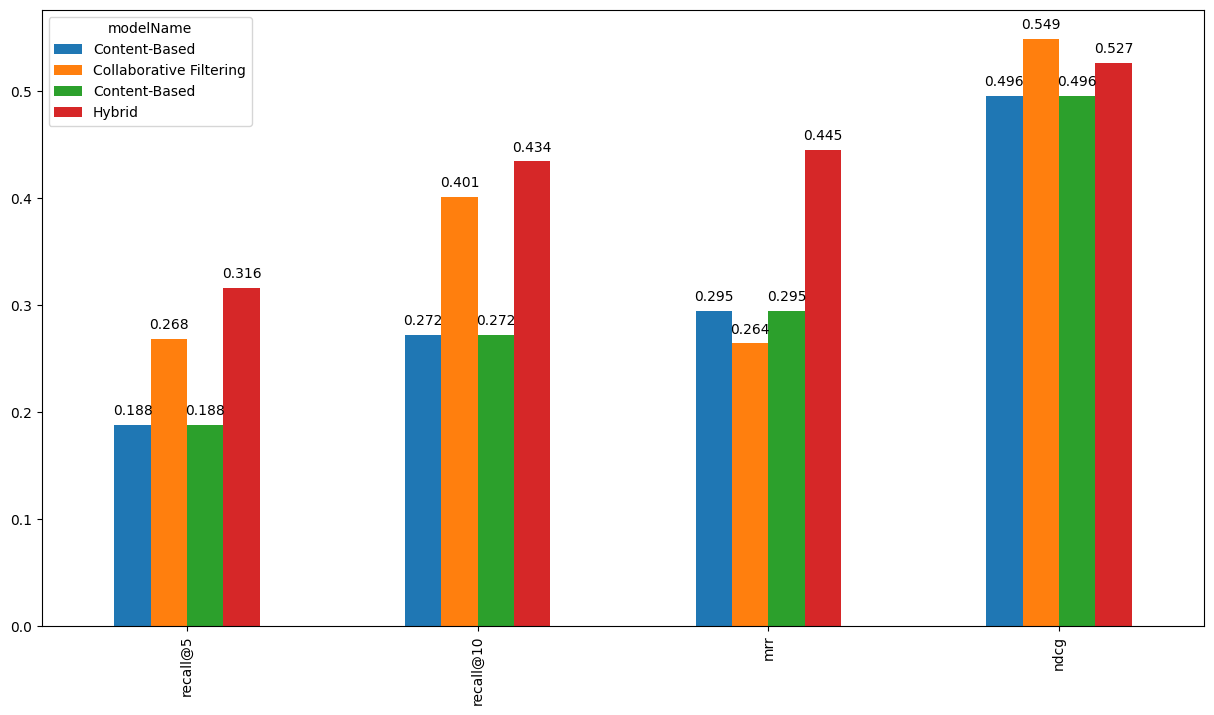

In [ ]:
%matplotlib inline
ax = global_metrics_df.transpose().plot(kind='bar', figsize=(15,8))
for p in ax.patches:
    ax.annotate("%.3f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')

In [ ]:
def inspect_interactions(person_id, test_set=True):
    if test_set:
        interactions_df = interactions_test_indexed_df
    else:
        interactions_df = interactions_train_indexed_df
    return interactions_df.loc[person_id].merge(articles_df, how = 'left',
                                                      left_on = 'contentId',
                                                      right_on = 'contentId') \
                          .sort_values('eventStrength', ascending = False)[['eventStrength',
                                                                          'contentId',
                                                                          'title', 'url', 'lang']]

In [ ]:
inspect_interactions(-1479311724257856983, test_set=False).head()

,eventStrength,contentId,title,url,lang
115,4.285402,7342707578347442862,"At eBay, Machine Learning is Driving Innovativ...",https://www.ebayinc.com/stories/news/at-ebay-m...,en
38,4.129283,621816023396605502,AI Is Here to Help You Write Emails People Wil...,http://www.wired.com/2016/08/boomerang-using-a...,en
8,4.044394,-4460374799273064357,"Deep Learning for Chatbots, Part 1 - Introduction",http://www.wildml.com/2016/04/deep-learning-fo...,en
116,3.954196,-7959318068735027467,Auto-scaling scikit-learn with Spark,https://databricks.com/blog/2016/02/08/auto-sc...,en
10,3.906891,2589533162305407436,6 reasons why I like KeystoneML,http://radar.oreilly.com/2015/07/6-reasons-why...,en


In [ ]:
hybrid_recommender_model.recommend_items(-1479311724257856983, topn=20, verbose=True)

,recStrengthHybrid,contentId,title,url,lang
0,0.466681,3269302169678465882,The barbell effect of machine learning.,http://techcrunch.com/2016/06/02/the-barbell-e...,en
1,0.413514,5092635400707338872,Power to the People: How One Unknown Group of ...,https://medium.com/@atduskgreg/power-to-the-pe...,en
2,0.395990,5258604889412591249,Machine Learning Is No Longer Just for Experts,https://hbr.org/2016/10/machine-learning-is-no...,en
3,0.344039,-9033211547111606164,Google's Cloud Machine Learning service is now...,https://techcrunch.com/2016/09/29/googles-clou...,en
4,0.321642,5250363310227021277,"How Google is Remaking Itself as a ""Machine Le...",https://backchannel.com/how-google-is-remaking...,en
5,0.303706,-7126520323752764957,"How Google is Remaking Itself as a ""Machine Le...",https://backchannel.com/how-google-is-remaking...,en
6,0.303542,7395435905985567130,The AI business landscape,https://www.oreilly.com/ideas/the-ai-business-...,en
7,0.299258,-5756697018315640725,Being A Developer After 40 - Free Code Camp,https://medium.freecodecamp.com/being-a-develo...,en
8,0.287972,1415230502586719648,Machine Learning Is Redefining The Enterprise ...,http://www.forbes.com/sites/louiscolumbus/2016...,en
9,0.285893,-8190931845319543363,Machine Learning Is At The Very Peak Of Its Hy...,https://arc.applause.com/2016/08/17/gartner-hy...,en
